In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import sys
import numpy as np
sns.set_context('poster')

Assumes that the following rsync has happened:

`rsync -av orchids-compute:/data1/urebbapr/MLOC/notebooks/vapor.data.h5 .`

## Reitan Approximation 

Ln(PWV)= 0.0633*Dewpoint – 17.4895.

### Load, preprocess the data

- turn dewpoint into Kelvin

In [2]:
F_H5 = 'vapor.data.h5'
KELVIN_OFFSET = 273.15
vapor_tst_df = pd.read_hdf(F_H5, '/preprocess/test')
vapor_trn_df = pd.read_hdf(F_H5, '/preprocess/train')

In [3]:
#vapor_tst_df.describe()
#vapor_trn_df.describe()

In [4]:
vapor_tst_df['dewpoint_kelvin'] = vapor_tst_df['dewpoint'] + KELVIN_OFFSET
vapor_trn_df['dewpoint_kelvin'] = vapor_trn_df['dewpoint'] + KELVIN_OFFSET

### Reitan Approximation Formula

Passed on by Preston Hooser.  Was informed that the dewpoint measurement here was measured in K.

```The Reitan approximation for PWV is as follows:
 
Ln(PWV)= 0.0633*Dewpoint – 17.4895.
```

In [5]:
a_orig = 0.0633
b_orig = -17.4895

In [6]:
def reitan(dewpoint_kelvin, a, b):
    return np.exp(a*dewpoint_kelvin+b)
# reitan_orig = np.exp(0.0633*vapor_tst_df['dewpoint_kelvin']-17.4895)

### Create a plotting script

In [7]:
def plot_true_v_pred_over_time(ax, start, end, true, pred, dewpoint=None, legend=True):
    # assumes we are inside a subplot and an axis was passed
    # assumes the index of true and pred are identical
    mask = (true.index >= start) & (true.index < end)
#     print(true[mask])
    ax.plot(true[mask], '.', label='water vapor')
    ax.plot(pred[mask], '.', label='reitan approx')
    if dewpoint is not None:
        axtwin = ax.twinx()
        axtwin.plot(dewpoint[mask], '.', color='g', label='dewpoint')
        axtwin.set_ylabel('Dewpoint (C)', color='g')
    if legend:
        ax.legend()
    ax.set_ylabel('PWV (cm)')

### Plot the Original Approximation

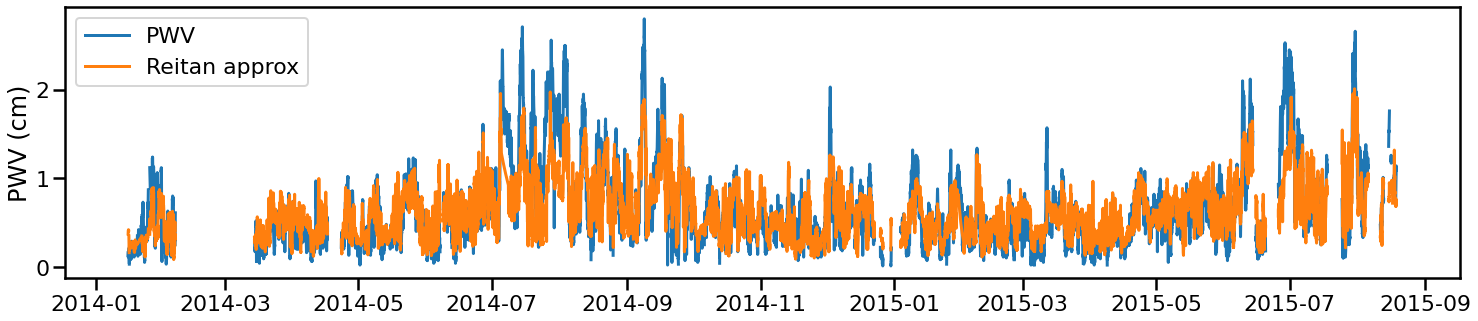

In [8]:
plt.figure(figsize=(25, 5))
plt.plot(vapor_tst_df.index, vapor_tst_df['water_vapor'], label='PWV')
plt.plot(vapor_tst_df.index, reitan(vapor_tst_df['dewpoint_kelvin'], a_orig, b_orig), label='Reitan approx')
plt.ylabel('PWV (cm)')
plt.legend()
plt.savefig('pwv.reitan.test.orig.png')

#### Zoom in on year 2014

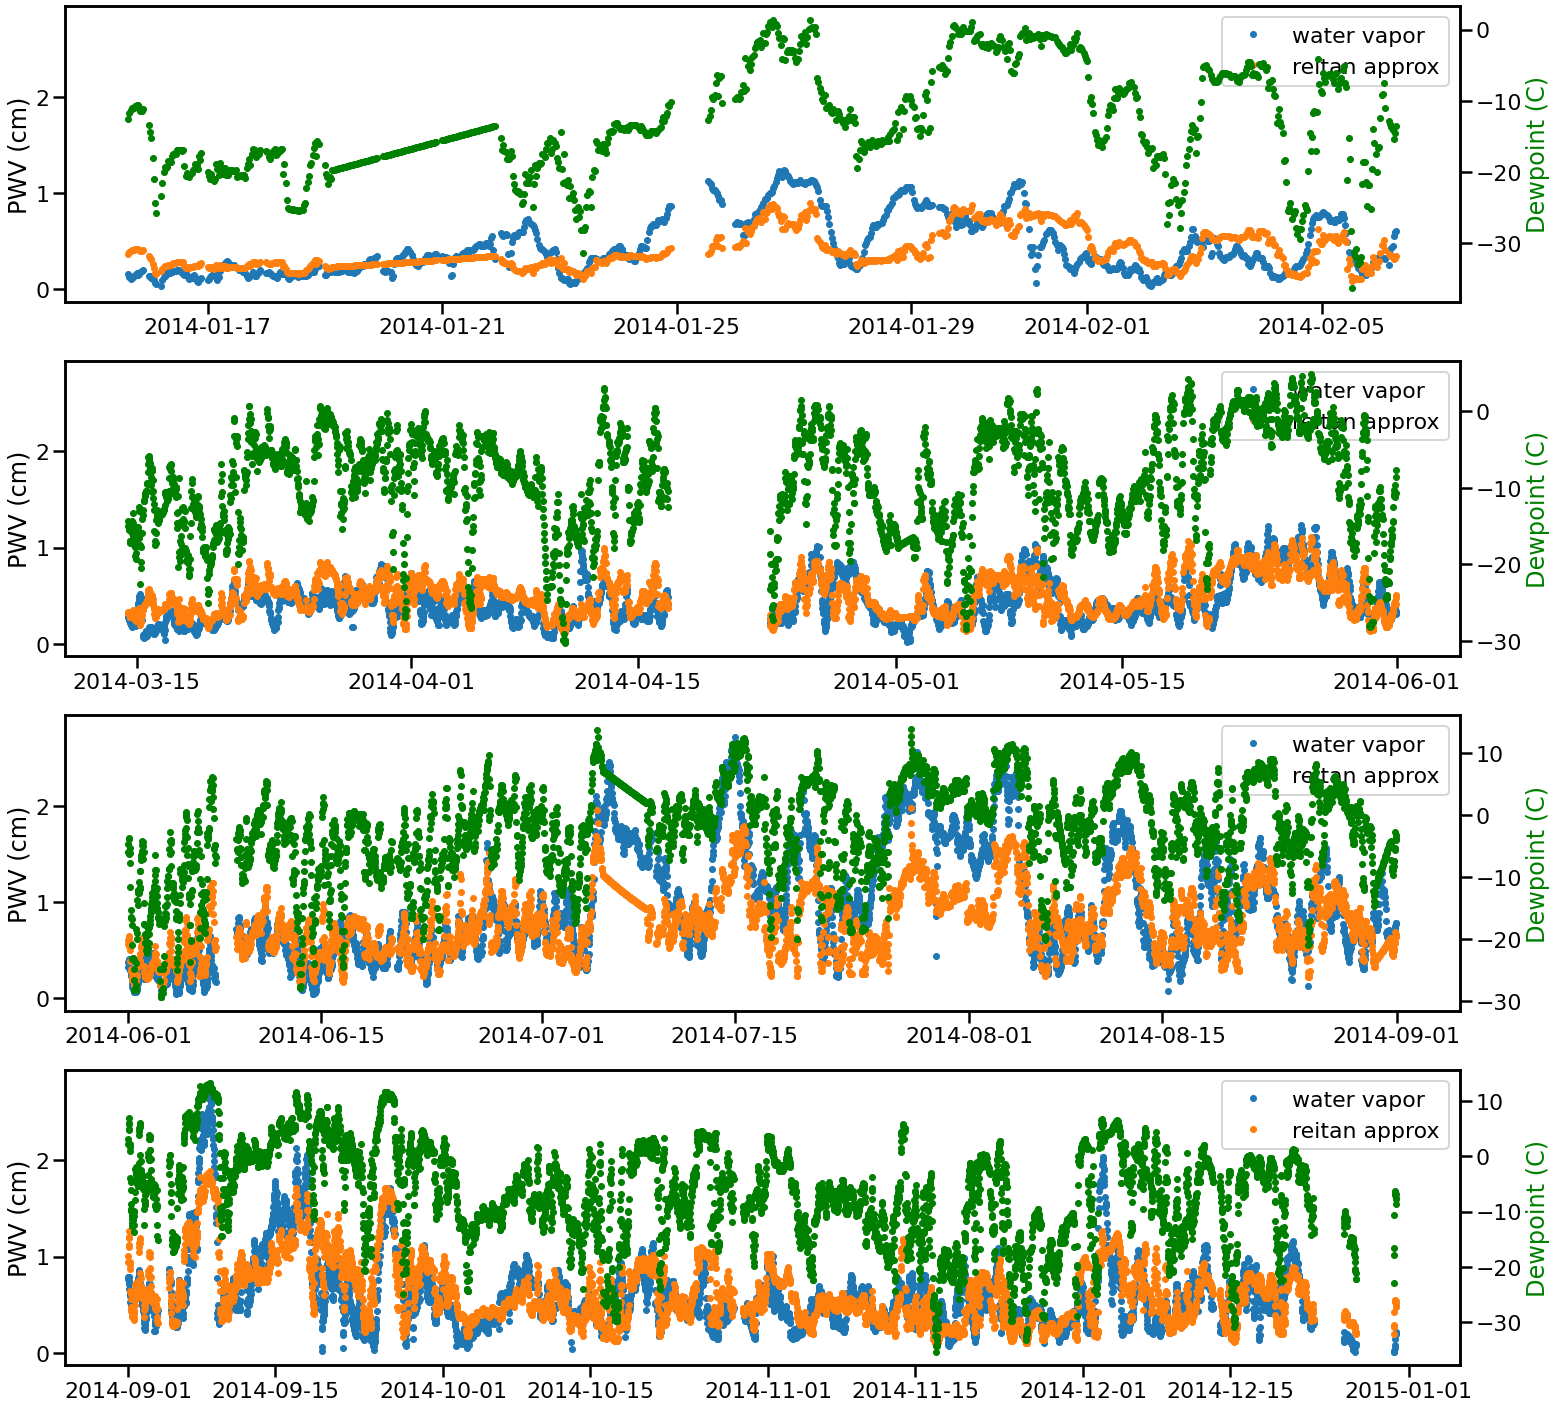

In [9]:
qs = ['2014-01-01', '2014-03-01', '2014-06-01', '2014-09-01', '2015-01-01']
fig, ax = plt.subplots(4, 1, figsize=(25, 25), sharey=True)
for i in range(4):
    j = i+1
    start, end = qs[i], qs[j]
    plot_true_v_pred_over_time(ax[i], start, end, vapor_tst_df['water_vapor'], reitan(vapor_tst_df['dewpoint_kelvin'], a_orig, b_orig), dewpoint=vapor_tst_df['dewpoint'])
    
plt.savefig('pwv.reitan.test.2014_by_quarter.orig.png')

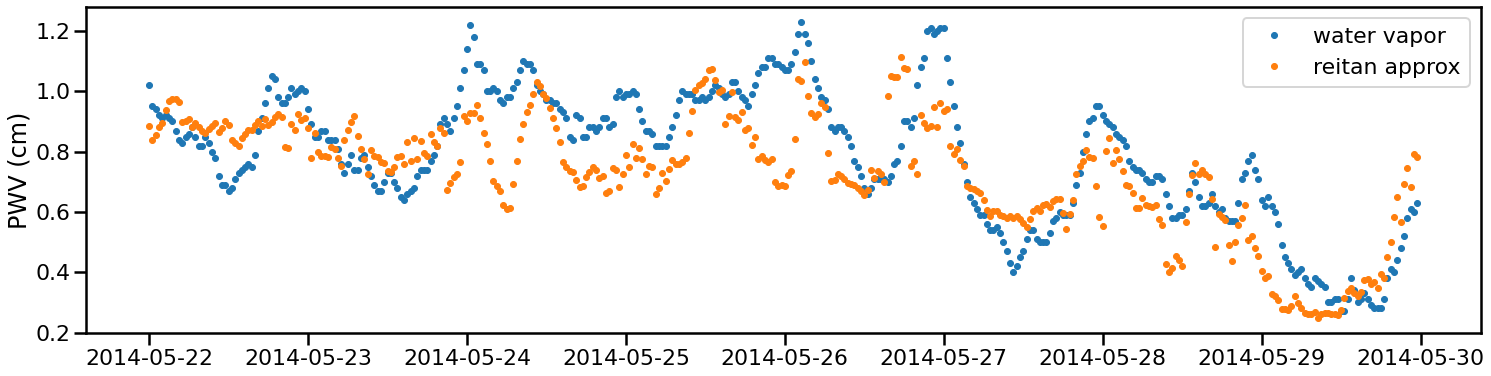

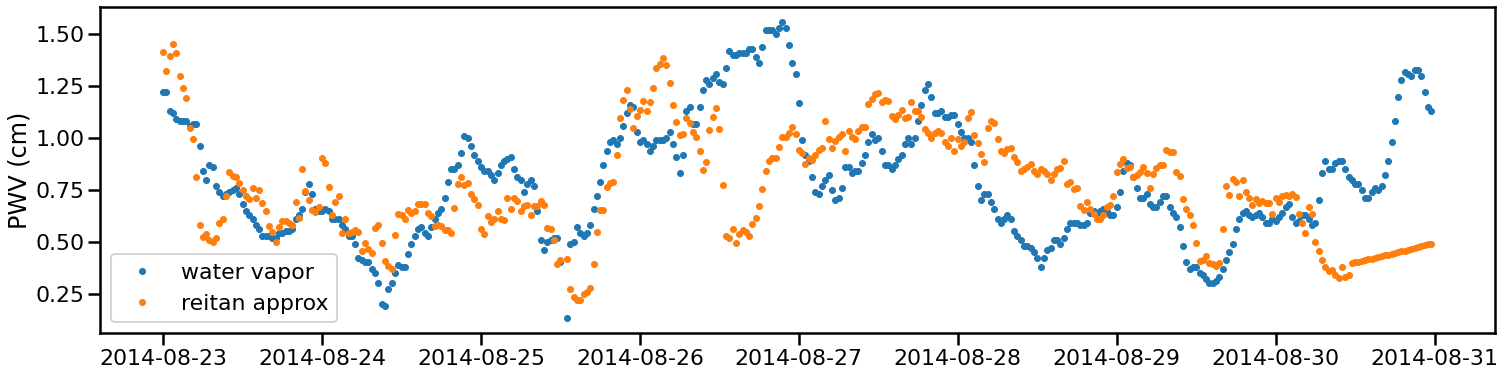

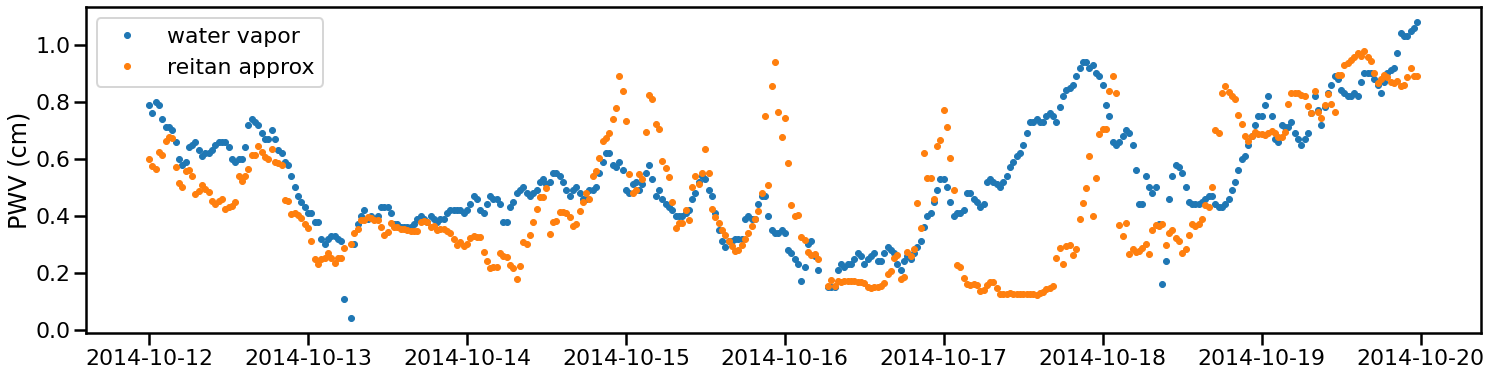

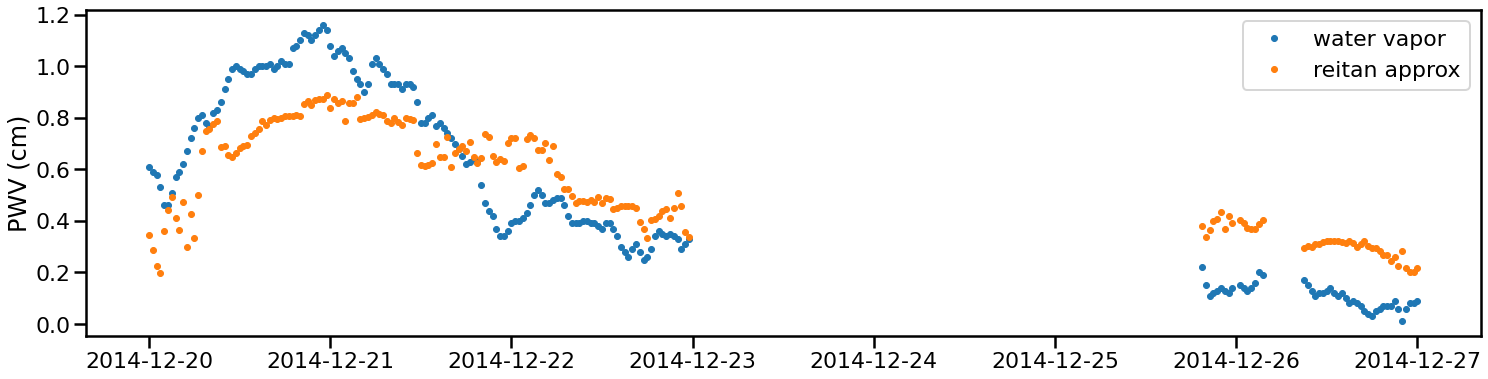

In [10]:
weeks = [('2014-05-22', '2014-05-30'),
         ('2014-08-23', '2014-08-31'),
         ('2014-10-12', '2014-10-20'),
         ('2014-12-20', '2014-12-28'),]
for i, week in enumerate(weeks):
    fig = plt.figure(figsize=(25, 6))
    start, end = week[0], week[1]
    plot_true_v_pred_over_time(plt.gca(), start, end, vapor_tst_df['water_vapor'], reitan(vapor_tst_df['dewpoint_kelvin'], a_orig, b_orig))
    plt.savefig('pwv.reitan.test.{}.{}.orig.png'.format(start,end))

### A toy example using curve_fit

In [11]:
import numpy as np
from scipy.optimize import curve_fit

def func(X, a, b, c):
    x,y = X
    return np.log(a) + b*np.log(x) + c*np.log(y)

# some artificially noisy data to fit
x = np.linspace(0.1,1.1,101)
y = np.linspace(1.,2., 101)
a, b, c = 10., 4., 6.
z = func((x,y), a, b, c) * 1 + np.random.random(101) / 100

# initial guesses for a,b,c:
p0 = 8., 2., 7.
print(curve_fit(func, (x,y), z, p0))

(array([10.06808065,  4.00170031,  5.99886629]), array([[ 1.92198994e-03,  1.01786022e-04, -3.15957490e-04],
       [ 1.01786022e-04,  5.50572885e-06, -1.66487045e-05],
       [-3.15957490e-04, -1.66487045e-05,  5.24461265e-05]]))


## Now do a machine learning approximation

I'm trying to figure out the optimal a and b that minimizes the least squares fitting

- so minimize in the least squares sense
- but you're trying to jointly optimize over two free parameters
- so I need to compute the residuals

In [12]:
vapor_tst_df_nonan = vapor_tst_df.dropna()
vapor_trn_df_nonan = vapor_trn_df.dropna()

In [13]:
coeff_tune, cov_tune = curve_fit(reitan, vapor_trn_df_nonan['dewpoint_kelvin'], vapor_trn_df_nonan['water_vapor'], (a_orig, b_orig))
a_tune, b_tune = coeff_tune
a_tune, b_tune

(0.08018388393024294, -22.0808111921837)

In [14]:
reitan_orig_nonan_trn = np.exp(a_orig*vapor_trn_df_nonan['dewpoint_kelvin']+b_orig)
reitan_orig_nonan_tst = np.exp(a_orig*vapor_tst_df_nonan['dewpoint_kelvin']+b_orig)
reitan_tune_nonan_trn = np.exp(a_tune*vapor_trn_df_nonan['dewpoint_kelvin']+b_tune)
reitan_tune_nonan_tst = np.exp(a_tune*vapor_tst_df_nonan['dewpoint_kelvin']+b_tune)

In [15]:
from sklearn.metrics import mean_squared_error
rms_orig_trn = mean_squared_error(vapor_trn_df_nonan['water_vapor'], reitan_orig_nonan_trn, squared=False)
rms_tune_trn = mean_squared_error(vapor_trn_df_nonan['water_vapor'], reitan_tune_nonan_trn, squared=False)
rms_orig_tst = mean_squared_error(vapor_tst_df_nonan['water_vapor'], reitan_orig_nonan_tst, squared=False)
rms_tune_tst = mean_squared_error(vapor_tst_df_nonan['water_vapor'], reitan_tune_nonan_tst, squared=False)

In [16]:
print(rms_orig_trn, rms_tune_trn)
print(rms_orig_tst, rms_tune_tst)

0.3017410819032643 0.2918198680544281
0.30773633342454454 0.3037468178767348


In [17]:
def plot_true_v_pred12_over_time(ax, start, end, true, pred1, pred2, pred1label, pred2label, legend=True):
    # assumes we are inside a subplot and an axis was passed
    # assumes the index of true and pred are identical
    mask = (true.index >= start) & (true.index < end)
    ax.plot(true[mask], '.', label='water vapor')
    ax.plot(pred1[mask], '.', label=pred1label)
    ax.plot(pred2[mask], '.', label=pred2label)
    if legend:
        ax.legend()
    ax.set_ylabel('PWV (cm)')

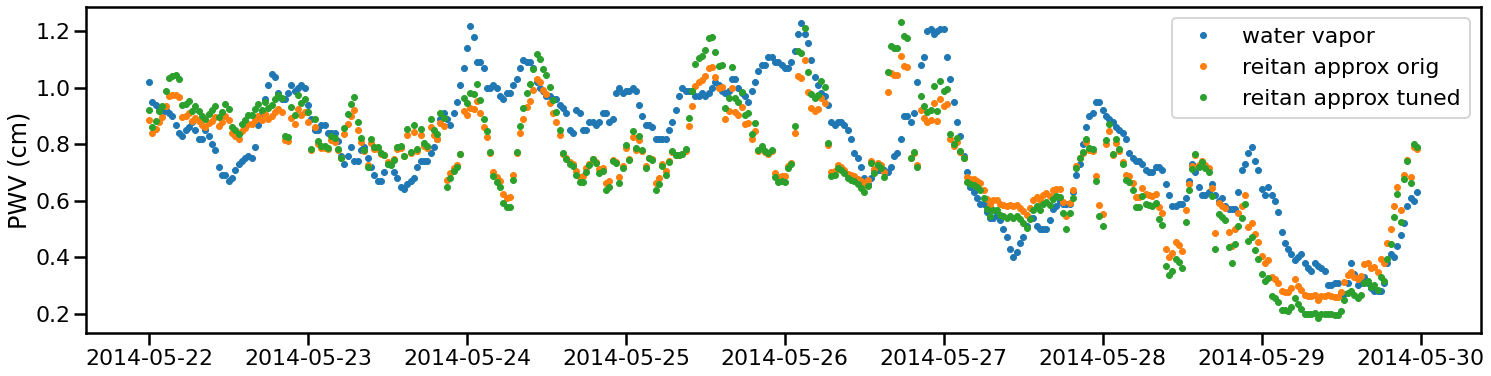

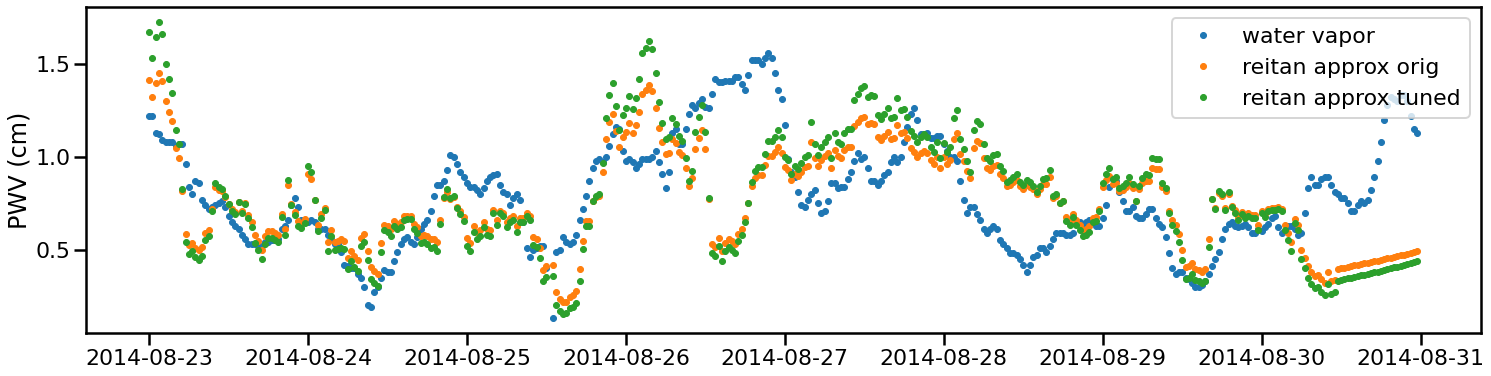

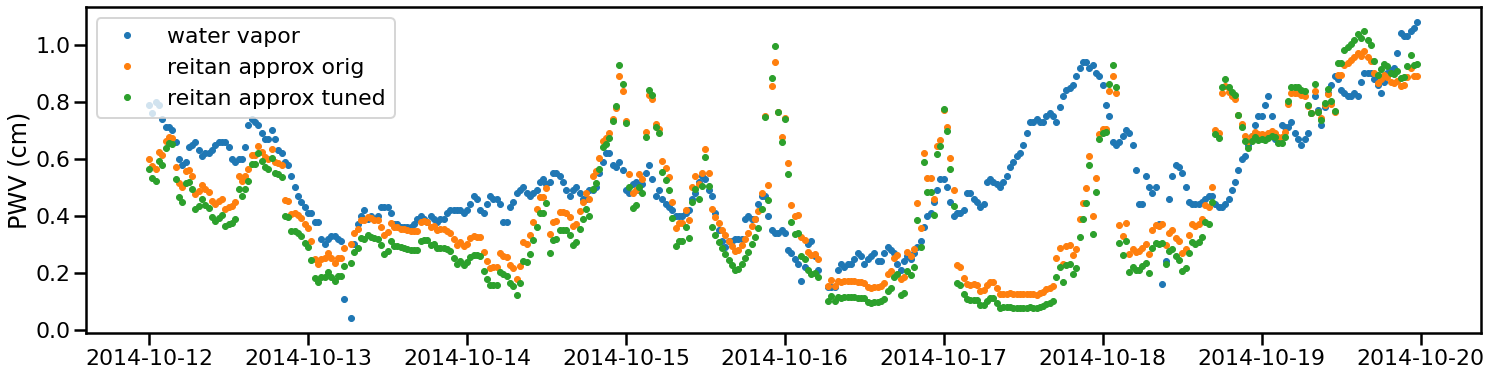

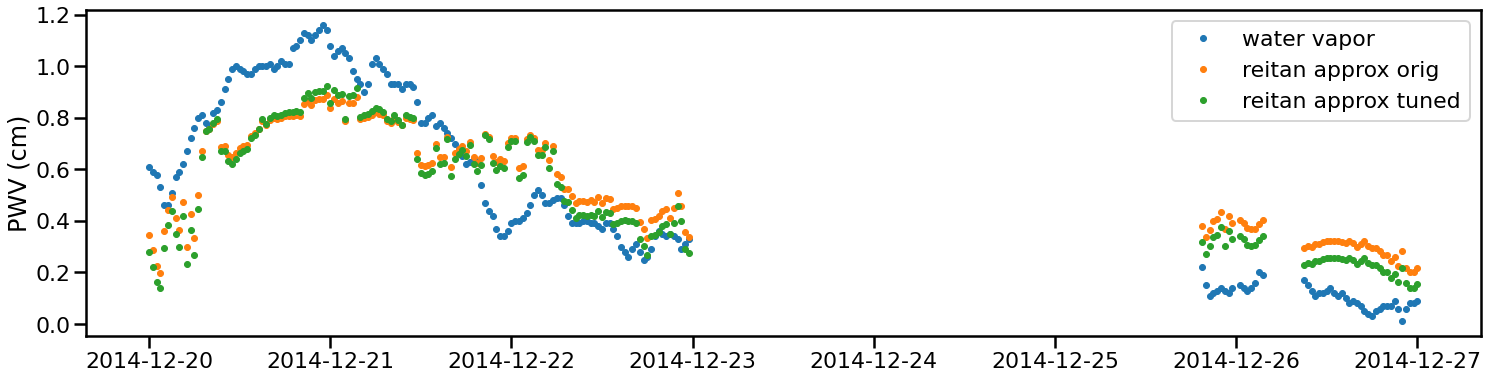

In [18]:
for i, week in enumerate(weeks):
    fig = plt.figure(figsize=(25, 6))
    start, end = week[0], week[1]
    plot_true_v_pred12_over_time(plt.gca(), start, end, vapor_tst_df_nonan['water_vapor'], reitan_orig_nonan_tst, reitan_tune_nonan_tst, 'reitan approx orig', 'reitan approx tuned' )
    plt.savefig('pwv.reitan.test.{}.{}.orig_v_tune.png'.format(start,end))

# Now we're going to tune month by month

In [19]:
vapor_trn_df_nonan.index.month == 7

array([ True,  True,  True, ..., False, False, False])

In [20]:
vapor_trn_df_nonan.count()

water_vapor           67578
wind_speed            67578
temperature           67578
humidity              67578
pressure              67578
dewpoint              67578
solar_zenith_angle    67578
day                   67578
minute                67578
dewpoint_kelvin       67578
dtype: int64

In [21]:
a_tune_month = []
b_tune_month = []
for m in np.arange(1, 13):
    month_mask = vapor_trn_df_nonan.index.month == m
    coeff_tune, cov_tune = curve_fit(reitan, vapor_trn_df_nonan.loc[month_mask,'dewpoint_kelvin'], vapor_trn_df_nonan.loc[month_mask,'water_vapor'], (a_tune, b_tune))
    a_tune, b_tune = coeff_tune
    a_tune_month.append(a_tune)
    b_tune_month.append(b_tune)

In [22]:
a_tune, b_tune

(0.05853617609802831, -16.32597539052021)

In [23]:
for a in a_tune_month:
    print(f"{a:.3}")

0.056
0.066
0.0509
0.047
0.0385
0.0549
0.0578
0.0662
0.0701
0.0666
0.0386
0.0585


In [24]:
for b in b_tune_month:
    print(f"{b:.5}")

-15.698
-18.536
-14.366
-13.305
-10.982
-15.266
-15.666
-18.099
-19.238
-18.471
-11.072
-16.326


In [25]:
def reitan_by_month(df, a_coeffs, b_coeffs):
    reitan_month = []
    for m in np.arange(1, 13):
        month_mask = df.index.month == m
        retain_approx_this_month = reitan(df.loc[month_mask,'dewpoint_kelvin'], a_coeffs[m-1], b_coeffs[m-1])
        reitan_month.append(retain_approx_this_month)
    return pd.concat(reitan_month).sort_index()

In [26]:
reitan_tune_nonan_trn_by_month = reitan_by_month(vapor_trn_df_nonan, a_tune_month, b_tune_month)
reitan_tune_nonan_tst_by_month = reitan_by_month(vapor_tst_df_nonan, a_tune_month, b_tune_month)

In [27]:
reitan_tune_nonan_tst_by_month.count()

23789

In [28]:
rms_tune_trn_by_month = mean_squared_error(vapor_trn_df_nonan['water_vapor'], reitan_tune_nonan_trn_by_month, squared=False)
rms_tune_tst_by_month = mean_squared_error(vapor_tst_df_nonan['water_vapor'], reitan_tune_nonan_tst_by_month, squared=False)

In [29]:
print(rms_orig_trn, rms_tune_trn, rms_tune_trn_by_month)
print(rms_orig_tst, rms_tune_tst, rms_tune_tst_by_month)

0.3017410819032643 0.2918198680544281 0.26509902802216456
0.30773633342454454 0.3037468178767348 0.291608406969727


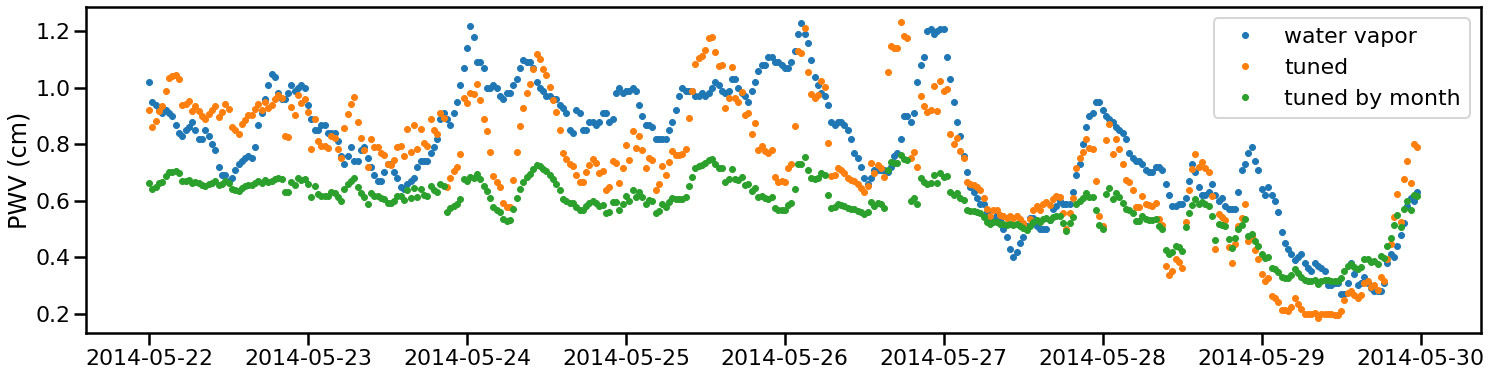

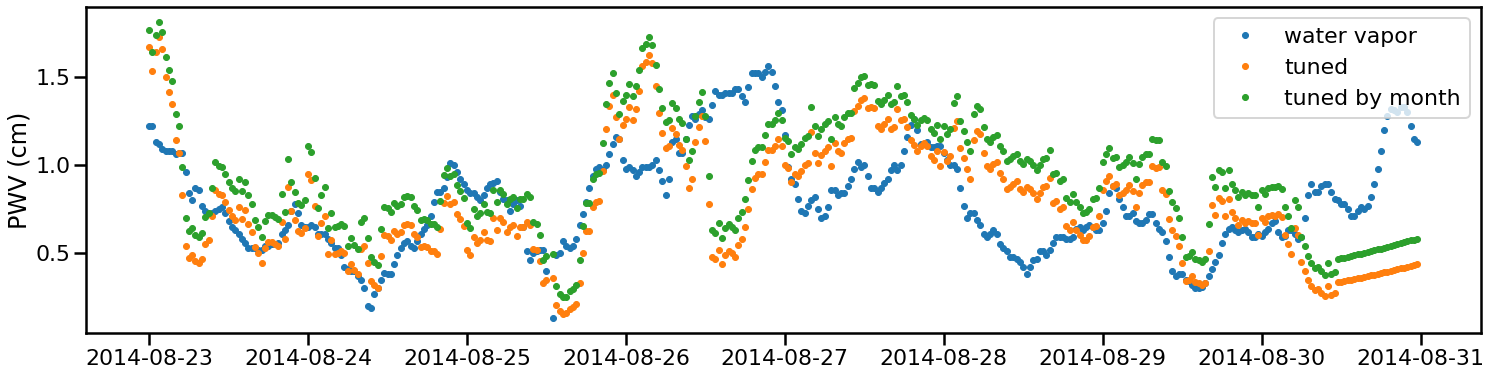

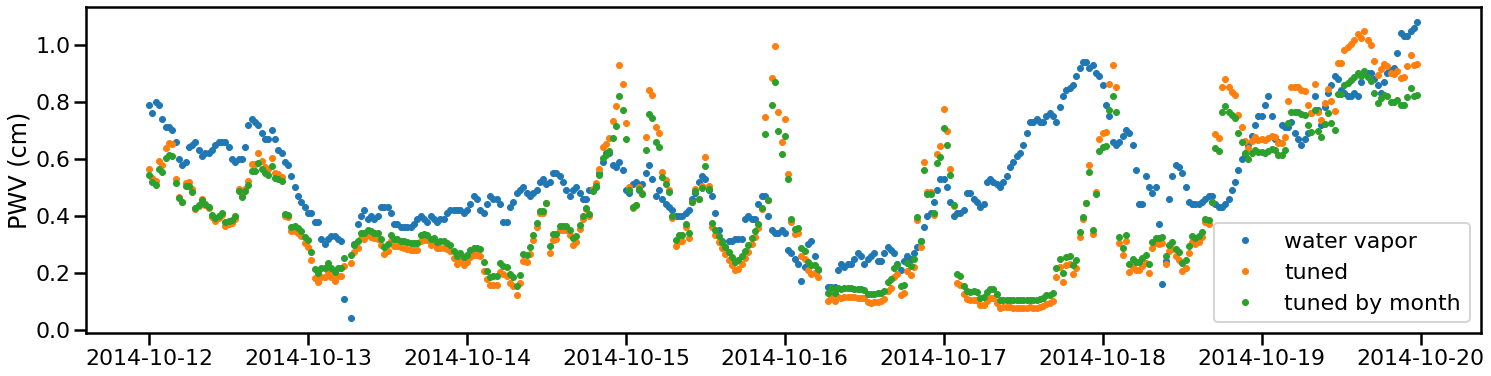

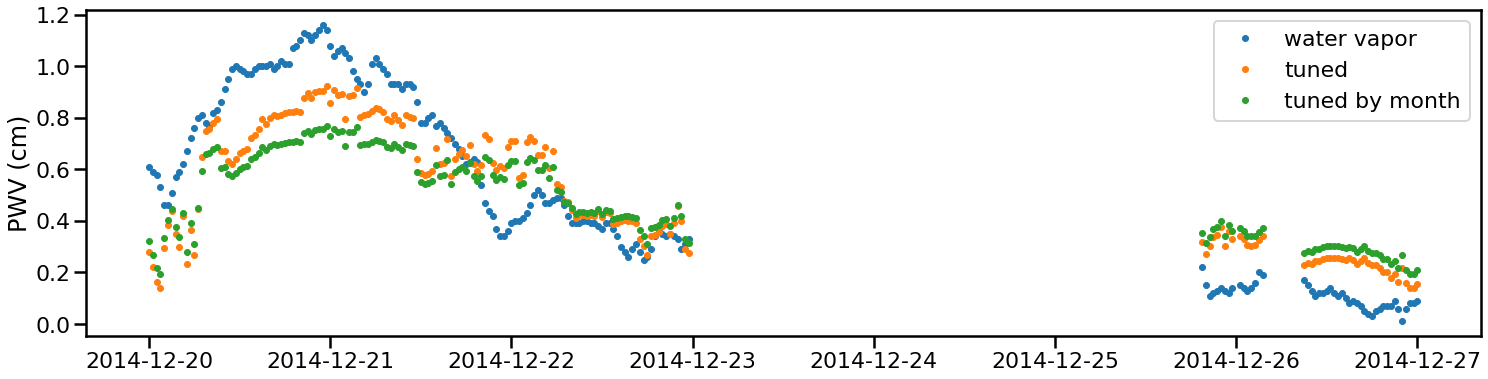

In [30]:
for i, week in enumerate(weeks):
    fig = plt.figure(figsize=(25, 6))
    start, end = week[0], week[1]
    plot_true_v_pred12_over_time(plt.gca(), start, end, vapor_tst_df_nonan['water_vapor'], reitan_tune_nonan_tst, reitan_tune_nonan_tst_by_month, 'tuned', 'tuned by month')
    plt.savefig('pwv.reitan.test.{}.{}.tune_v_tune_by_month.png'.format(start,end))